Proposal for Group 42

Let's upload our possible datasets in the data folder so we can easily have a look at them and possibly run some functions on them if we need. 

Introduction:
Cardiovascular diseases, which kill approximately 17 million people in the world, include heart attacks, heart strokes, and heart failure. Heart failure is caused when the heart cannot successfully send the required amount of blood to the body (Chicco, 2020). In this project, we will predict what factors determine whether patients can survive after heart failure. We will use dataset "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", which collects the data of 299 patients after heart failure at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad during April to December 2015. 


In [19]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

In [20]:
#reads in data as well as turns relevant double columns into factors 

url<- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"


heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia)) #%>% 
    #select(creatinine_phosphokinase, ejection_fraction, platelets, DEATH_EVENT)


#creates factor levels for columns that make sense with column name 
levels(heart_data$sex)<- c("female","male")
levels(heart_data$smoking)<- c("no","yes")
levels(heart_data$DEATH_EVENT)<- c("died","survived")
levels(heart_data$high_blood_pressure)<- c("no","yes")
levels(heart_data$diabetes)<- c("no","yes")
levels(heart_data$anaemia)<- c("no","yes")


#normalize platelets column so that all values are a fraction of the max value 
max_plat<- max(heart_data$platelets)
heart_data_platelets_norm <- heart_data%>%
    mutate(platelets_norm = platelets/max_plat)%>%
    select(-platelets)%>%
    relocate(platelets_norm, .before = serum_creatinine)

 




Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



Possible Predictive Questions
-Does a patient have high blood pressure if they smoke and have diabetes?
-Will a patient experience a death event if they smoke, have high blood pressure and are over 70?
-If a patient smokes and has low platelet(less than 25% of max platelet in study) count will they have anaemia?

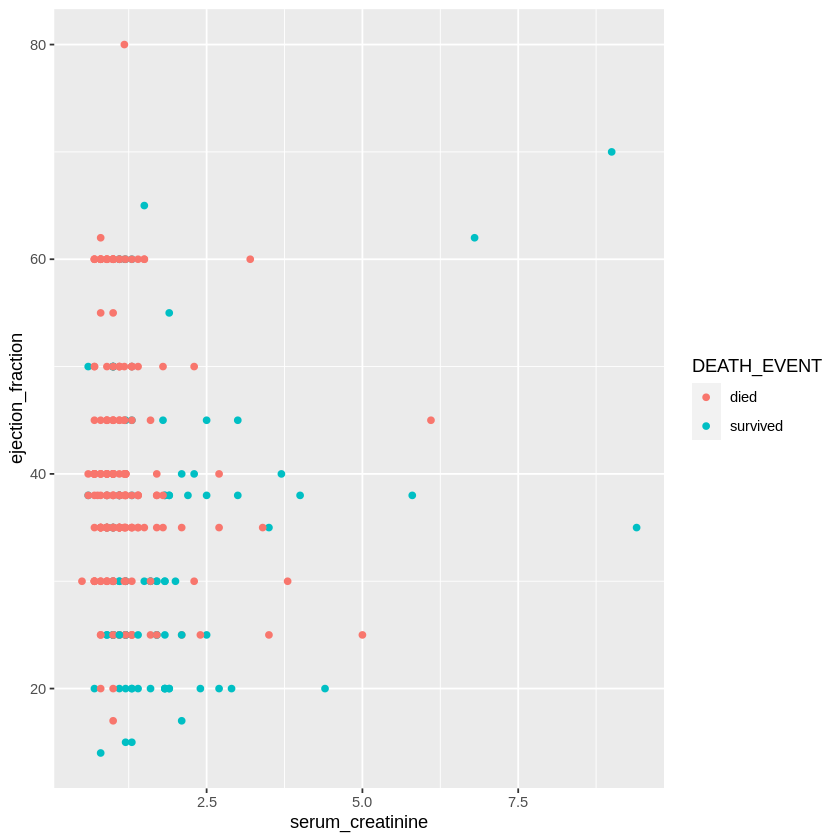

In [21]:
#example question if we were to look at how serum creatinine and ejection fraction can be used as predictors of a death event

serum_data <- heart_data%>%
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT))+
    geom_point()
    

serum_data

In [22]:
#looking at the percentage of affermatives and negatives for each possible catergorical class to give a reason about why we chose DEATH_EVENT
num_obs <- nrow(heart_data)
anaemia_dist <- heart_data %>% 
  group_by(anaemia) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
diabetes_dist <- heart_data %>% 
  group_by(diabetes) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
bp_dist <- heart_data %>% 
  group_by(high_blood_pressure) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
death_dist <- heart_data %>% 
  group_by(DEATH_EVENT) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

anaemia_dist
diabetes_dist
bp_dist
death_dist

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



anaemia,count,percentage
<fct>,<int>,<dbl>
no,170,56.85619
yes,129,43.14381


diabetes,count,percentage
<fct>,<int>,<dbl>
no,174,58.19398
yes,125,41.80602


high_blood_pressure,count,percentage
<fct>,<int>,<dbl>
no,194,64.88294
yes,105,35.11706


DEATH_EVENT,count,percentage
<fct>,<int>,<dbl>
died,203,67.89298
survived,96,32.10702


The distribution of all categorical classes can be seen above, since range of their distrubutions is within 10, statistically any of them can be chosen as a viable class to predict. However, due to the medical significance and strength of corelation to the features, we decided to choose "DEATH_EVENT" as the class which we will try to predict.

Following this analysis, all other categorical data types were removed from the dataframe. 

Expected outcomes and significance

We expect to find that platelet count, serum creatine, and ejection fraction can accuratly predict if a patient who has already suffered heart failure is likely to survive in the following days. By taking these predictors and applying them to new patients who have suffered heart failure we can make accurate predictions about what the this patients survival in the following days after their heart failure. This can help hospitals identify which patients will need special care and treatment in the following days after heart failure in order to increase chance of survival. Future studies may want to recreate this study in other datasets as well as larger datasets in order to improve reliability. They may also want to look at these variables as predictors for other diseases and illnesses such as renal failure and high blood pressure.


In [24]:
# CODE TO SELECT THE BEST PREDICTOR VARIABLES

# # remove categorical columns from the dataset and only keep numerical
# heart_numerical <- heart_data %>% 
#     select(-anaemia, -diabetes, -high_blood_pressure, -sex, -smoking, -time)

# #Evaluate which predictive variables to choose

# # create object of names of all predictive variables
# names <- colnames(heart_numerical %>% select(-DEATH_EVENT))

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) %>% 
#      set_engine("kknn") %>% 
#      set_mode("classification")

# # create a 5-fold cross-validation object
# heart_vfold <- vfold_cv(heart_numerical, v = 5, strata = DEATH_EVENT)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         heart_recipe <- recipe(as.formula(model_string), 
#                                 data = heart_numerical) %>% 
#                           step_scale(all_predictors()) %>% 
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() %>% 
#           add_recipe(heart_recipe) %>% 
#           add_model(knn_spec) %>% 
#           tune_grid(resamples = heart_vfold, grid = 10) %>% 
#           collect_metrics() %>% 
#           filter(.metric == "accuracy") %>% 
#           summarize(mx = max(mean))
#         acc <- acc$mx %>% unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies %>% 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }

# accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ ejection_fraction,0.6826748
2,DEATH_EVENT ~ ejection_fraction+age,0.7590720
3,DEATH_EVENT ~ ejection_fraction+age+serum_creatinine,0.7564055
4,DEATH_EVENT ~ ejection_fraction+age+serum_creatinine+serum_sodium,0.7466278
5,DEATH_EVENT ~ ejection_fraction+age+serum_creatinine+serum_sodium+platelets,0.7431249
6,DEATH_EVENT ~ ejection_fraction+age+serum_creatinine+serum_sodium+platelets+creatinine_phosphokinase,0.7364601
